# Student Name: Rohit Bhadoria


# TASK 1: Identify one or more suitable web APIs

<b>Data Analysis on Reddit Data 

This notebook Performs Data Analysis using the real time reddit API. 
    <br>It collects all the posts on topic Data Science and comments on these posts and derives insight using this data.
    <br> praw Library provided by Reddit for python was used to collect the required data.</b>

<b>Import the required modules for the data analysis</b>

In [170]:
import praw
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Task 2,3: Collect data from your chosen API(s) and Parse the collected data, and store it in an appropriate file format
<b>Using praw (python API for accessing reddit data) create an object using personal authentication</b>

In [171]:
reddit = praw.Reddit(client_id='******',
                     client_secret='*******',
                     user_agent='Ass1/0.1 by brohit64')

<b>Below function takes CommentsForest Object as input (which is a tree of comments for 1 post) and creates one row of each comment that has been made on the post and loads it into file comments.csv</b>

In [172]:
def iocomments(comments):
 global comments_writer
 for comment in comments:
  comments_writer.writerow([id,comment.author,comment.body,comment.created_utc,comment.score,comment.is_submitter,comment.parent_id])
  if(comment.replies):
   iocomments(comment.replies)					 

<b>
    Below piece of code performs following tasks in order: <br>
1) Opens Files posts.csv and comments.csv in write mode for loading data from Reddit<br>
2) use endcoding = 'utf-8' to take care of special characters<br>
3) For each post in topic Data Science store the respective fields in posts.csv <br>
4) Pass the CommentForest Object to the function that was create above to load the comments.csv file<br>
    </b>

In [4]:
with open('posts.csv', mode='w', encoding="utf-8", newline='') as posts, open('comments.csv', mode='w', encoding="utf-8", newline='') as comments:
 posts_writer = csv.writer(posts, delimiter=',')
 comments_writer = csv.writer(comments, delimiter=',')
 posts_writer.writerow(["id","author","created_utc","num_comments","score","title","upvote_ratio","clicked","edited"])
 comments_writer.writerow(["id","author","body","created_utc","score","is_submitter","parent_id"])
 for id, submission in enumerate(reddit.subreddit("datascience").top(limit=2000), 1):
  posts_writer.writerow([id,submission.author,submission.created_utc,submission.num_comments,submission.score,submission.title,submission.upvote_ratio,submission.clicked,submission.edited])
  submission.comments.replace_more(limit=None)
  iocomments(submission.comments)

# Task 4: Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data

<b>As the 2 files are csv we are going to load those files as pandas dataframes</b>

In [184]:
posts = pd.read_csv("posts.csv")
posts.head()

,id,author,created_utc,num_comments,score,title,upvote_ratio,clicked,edited
0,1,keymado,1.547749e+09,86,1709,:),0.97,False,False
1,2,rohan36,1.545385e+09,33,949,xkcd: Machine Learing,0.96,False,False
2,3,c1nv1n,1.550781e+09,174,918,Being a recent graduate,0.92,False,False
3,4,bbennett36,1.547141e+09,78,902,Don't be this guy. (x-post from r/programmerhu...,0.97,False,False
4,5,mr_dicaprio,1.552953e+09,62,884,Map of Data Science,0.93,False,False


In [185]:
comments = pd.read_csv("comments.csv")
comments.head()

,id,author,body,created_utc,score,is_submitter,parent_id
0,1,nerdponx,"Machine learning is so 2017. Try ""AI-powered m...",1.547753e+09,207,False,t3_ah0q69
1,1,ColonelMorrison,"There's gotta be a ""deep"" in there somewhere",1.547755e+09,101,False,t1_eeamvmc
2,1,abdolfhitcoln420,Deep neural machine learning AI network,1.547756e+09,78,False,t1_eeapx3n
3,1,senbonshowers,Reinforced gpu-accelerated deep neural machine...,1.547761e+09,42,False,t1_eearevq
4,1,Boxy310,>>Yeah we've decided to run a deep learning es...,1.547765e+09,12,False,t1_eeayk6c


<b>created_utc is in unix timestamp form. Thus, we will change it to date time format</b>

In [186]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)
comments_timestamp = comments["created_utc"].apply(get_date)
comments = comments.assign(created_utc = comments_timestamp)
posts_timestamp = posts["created_utc"].apply(get_date)
posts = posts.assign(created_utc = posts_timestamp)
display(HTML(comments[["id","created_utc"]].head().to_html()))
display(HTML(posts[["id","created_utc"]].head().to_html()))

,id,created_utc
0,1,2019-01-17 19:31:07
1,1,2019-01-17 20:03:26
2,1,2019-01-17 20:19:44
3,1,2019-01-17 21:36:50
4,1,2019-01-17 22:50:40


,id,created_utc
0,1,2019-01-17 18:22:03
1,2,2018-12-21 09:37:32
2,3,2019-02-21 20:29:45
3,4,2019-01-10 17:21:34
4,5,2019-03-18 23:52:21


<b>create function to preprocess text and return a string of nouns to make a wordcloud later</b>

In [187]:
def wordcloudText(df):
 stopwords=set(STOPWORDS)

 text = " ".join(review for review in df)
 text = nltk.word_tokenize(text)
 tagged = nltk.pos_tag(text)                  
 nouns = [tag[0].lower() for tag in tagged if tag[1]=='NN']
 text = " ".join(nouns)

 stopwords.update(["something","way","point","lot","thing","stuff","part","anyone"])
 return (stopwords, text)

<b> Below function trends() returns 2 dataframes:<br>
    comments_trend: contains YearMonth and total comments in that yearmonth<br>
    posts_trend: contains YearMonth and total posts in that yearmonth.
</b>

In [188]:
def get_date2(created):
    return int(str(created.year)+str('%02d' % (created.month*8.33)))   ##multiplied by 8.33 as to plot 12 months for range of 100 

In [190]:
def trends():
 global posts, comments
 posts_ym = posts["created_utc"].apply(get_date2)
 posts = posts.assign(Created_YearMonth = posts_ym)
 comments_ym = comments["created_utc"].apply(get_date2)
 comments = comments.assign(Created_YearMonth = comments_ym)
 posts_trend = posts.sort_values(["Created_YearMonth"]).groupby(["Created_YearMonth"])["Created_YearMonth"].count().reset_index(name="count")
 comments_trend = comments.sort_values(["Created_YearMonth"]).groupby(["Created_YearMonth"])["Created_YearMonth"].count().reset_index(name="count")
 return comments_trend, posts_trend   

# Task 5: Analyse and summarise the cleaned dataset
<b>Checking general stats of each dataframe</b>

In [192]:
print(comments.describe())
print()
print(comments.info())

                 id         score  Created_YearMonth
count  31502.000000  31502.000000       31502.000000
mean     393.192020      5.845915      201837.710495
std      288.028061     14.383934          84.574649
min        1.000000    -69.000000      201433.000000
25%      132.000000      1.000000      201808.000000
50%      347.000000      2.000000      201866.000000
75%      617.000000      5.000000      201899.000000
max      995.000000    348.000000      201924.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31502 entries, 0 to 31501
Data columns (total 8 columns):
id                   31502 non-null int64
author               29575 non-null object
body                 31502 non-null object
created_utc          31502 non-null datetime64[ns]
score                31502 non-null int64
is_submitter         31502 non-null bool
parent_id            31502 non-null object
Created_YearMonth    31502 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(3), object(3)
memory usag

<b>In above results we can see that: <br>1) mean score of comments is almost 6 (which is upvotes - downvotes ) <br> 2) All columns have non null values except for "Author" which has 31470-29543 = 1927 missing values which we will ignore for now and treat it later as per requirement</b>

In [193]:
print(posts.describe())
print()
print(posts.info())

               id  num_comments        score  upvote_ratio  Created_YearMonth
count  996.000000    996.000000   996.000000    996.000000         996.000000
mean   498.500000     31.064257   116.968876      0.936938      201810.615462
std    287.664735     35.916540   124.167710      0.044608          90.845563
min      1.000000      0.000000    39.000000      0.690000      201433.000000
25%    249.750000      9.000000    55.000000      0.910000      201758.000000
50%    498.500000     20.000000    77.000000      0.950000      201833.000000
75%    747.250000     39.000000   127.250000      0.970000      201883.000000
max    996.000000    478.000000  1709.000000      1.000000      201924.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 10 columns):
id                   996 non-null int64
author               969 non-null object
created_utc          996 non-null datetime64[ns]
num_comments         996 non-null int64
score                9

<b>In above results we can see that: <br>1) mean score of posts is almost 117 (which is upvotes - downvotes ) denoting these are indeed the top posts on the topic <br> 2) The mean upvote_ratio is 0.936948(upvotes/total votes) and thus, these posts were liked by Majority. <br> 3) All columns have non null values</b>

<b>Plot depicting how count of comments and posts has changed over the years</b>

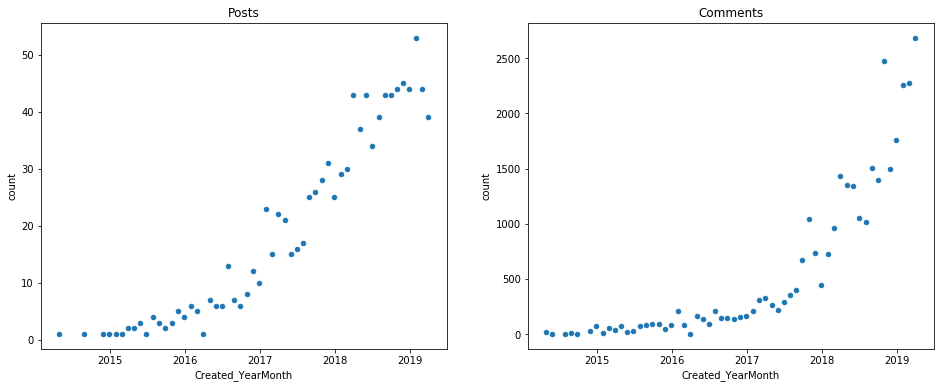

In [194]:
comments_trend, posts_trend = trends()
fig, axes = plt.subplots(nrows=1, ncols=2)

ax = posts_trend.plot(figsize=(16, 6), kind="scatter",x="Created_YearMonth",y="count", title="Posts", ax=axes[0])
ax.set_xticklabels([2014,2015,2016,2017,2018,2019])
ax = comments_trend.plot(figsize=(16, 6), kind="scatter",x="Created_YearMonth",y="count", title="Comments", ax=axes[1])
ax.set_xticklabels([2014,2015,2016,2017,2018,2019])
print()

<b>From the above results it is quite evident that interest in Machine Learning has certainly increased in the previous years and also Reddit has progressed a lot as the preferred place for discussions</b>

<b><br>In the below piece of code we find out following:<br>
    1) Total contributors for Comments and Posts<br> 
    2) top 10 contributors for Comments and Posts based on number of Comments and Posts<br>
    3) top 10 contributors for Comments and Posts based on Hightest Score
</b>

Total Contributors for Machine Learning Comments: 8201
Total Contributors for Machine Learning Posts: 787


                                Top 10 Contributors according to number of comments:



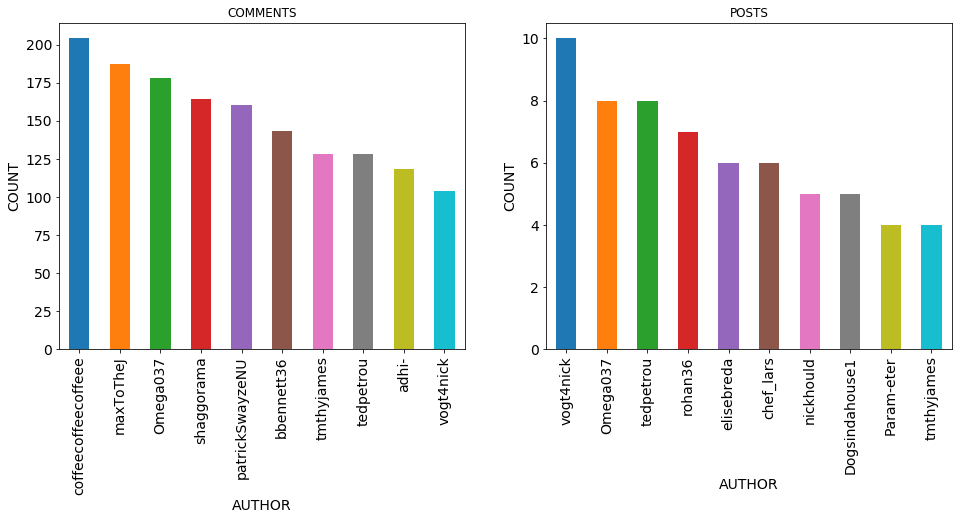

In [195]:
author_comments = comments[(comments.author.notnull())]['author'].value_counts()
author_posts = posts[(posts.author.notnull())]['author'].value_counts()

print("Total Contributors for Machine Learning Comments: {}".format(author_comments.count()))
print("Total Contributors for Machine Learning Posts: {}".format(author_posts.count()))

print()
print()
print("                                Top 10 Contributors according to number of comments:")

fig, axes = plt.subplots(nrows=1, ncols=2)
ax2 = author_posts.head(10).plot.bar(figsize=(16,6),fontsize=14, ax=axes[1], title="POSTS")
ax2.set_xlabel("AUTHOR",fontsize=14)
ax2.set_ylabel("COUNT",fontsize=14)
ax= author_comments.head(10).plot.bar(figsize=(16,6),fontsize=14, ax=axes[0], title="COMMENTS")
ax.set_xlabel("AUTHOR",fontsize=14)
ax.set_ylabel("COUNT",fontsize=14)
print()



                                Top 10 Contributors according to Score(Upvotes-DownVotes):



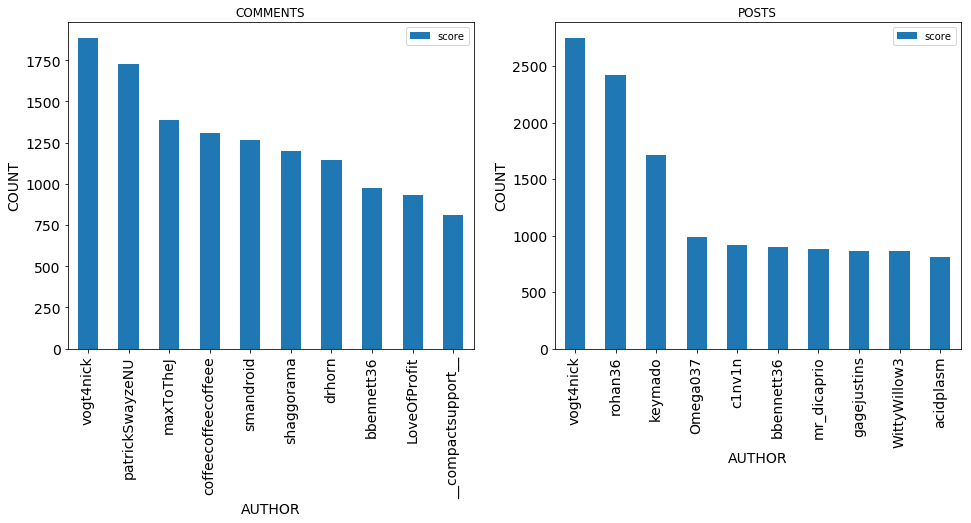

In [196]:
author_posts = posts[(posts.author.notnull())].groupby(["author"])["author","score"].sum().sort_values(by="score",ascending=False).head(10)
author_comments = comments[(comments.author.notnull())].groupby(["author"])["author","score"].sum().sort_values(by="score",ascending=False).head(10)    

print()
print()
print("                                Top 10 Contributors according to Score(Upvotes-DownVotes):")

fig, axes = plt.subplots(nrows=1, ncols=2)
ax2 = author_posts.head(10).plot.bar(figsize=(16,6),fontsize=14, ax=axes[1], title="POSTS")
ax2.set_xlabel("AUTHOR",fontsize=14)
ax2.set_ylabel("COUNT",fontsize=14)
ax= author_comments.head(10).plot.bar(figsize=(16,6),fontsize=14, ax=axes[0], title="COMMENTS")
ax.set_xlabel("AUTHOR",fontsize=14)
ax.set_ylabel("COUNT",fontsize=14)
print()

<b>In the below 2 cells we have created 2 wordclouds for the top 20 buzzwords in Machine Learning: <br>
    1) Field in comments <br>
    2) Post Topics <br> </b>

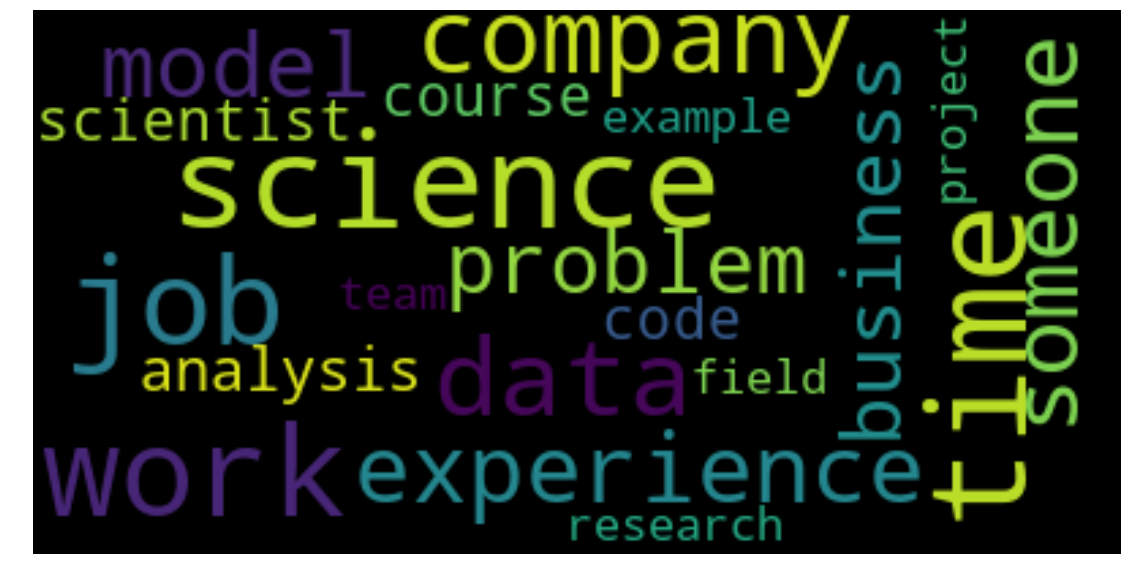

In [197]:
stopwords, text =  wordcloudText(comments.body)

wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=20).generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

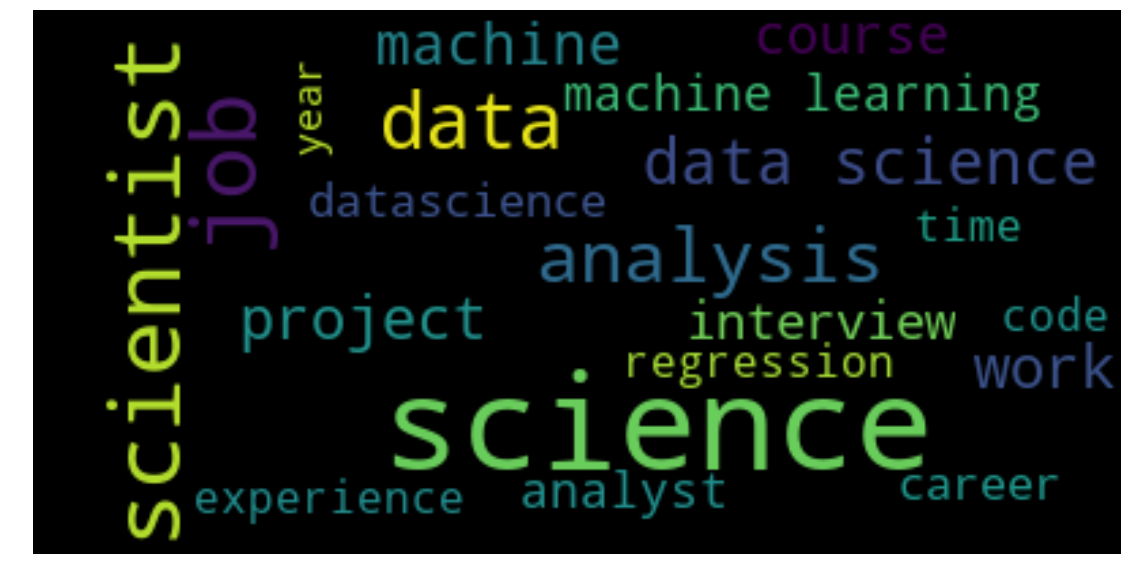

In [198]:
stopwords, text =  wordcloudText(posts.title)

wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=20).generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<b>In below cell we have analysed if there is any correlation between upvote_ratio and score</b>


Correlation Between score and upvote_ratio: 0.1906825363918894


          Regression Plot score vs upvote_ratio:


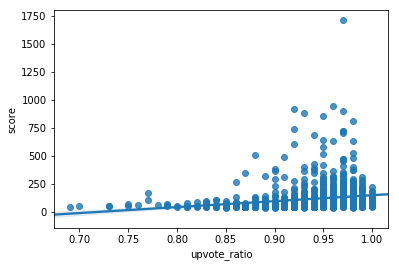

In [199]:
print("\nCorrelation Between score and upvote_ratio: {}\n".format(posts['score'].corr(posts['upvote_ratio'])))
print("\n          Regression Plot score vs upvote_ratio:")
ax = sns.regplot(x=posts['upvote_ratio'], y=posts['score'], data=posts)

# TASK 6: Insights offered by this analysis is as below:<br>
<b>1) These posts can be used to represent general public opinion on Machine Learning due to the following features:<br>
Score(upvotes - downvotes ):<br>
mean score of comments = 6 <br>
mean score of posts = 117  <br>
<br>
mean upvote_ratio(upvotes/total votes)  = 0.936948<br><br>
2) Interest in Machine Learning has increased a lot over the years according to the scatter plots drawn above between "number of posts", "number of coments" vs "Year Month of Post" <br><br>
3) The buzzwords according to WordCloud are centred around job, experience, data science. Thus, most of the discussions have been around people seeking jobs in data science.
<br><br>4) Top 10 contributors in Posts and Comments and their comparison using bar graph<br><br>
5) Though it may seem upvite_ratio and score are related but there is minimal correlation between them. Thus, they cannot be used interchangably and each one should be used as per the usecase.
 